In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore') #경고메시지 숨기기

#모델1.Auto-ARIMA

AutoARIMA는 ARIMA 모델의 차수(p,d,q)와 계절성 차수(P,D,Q,m)를 자동으로 선택해주는 모델입니다.

지난시간 수동 ARIMA와 SARIMA 모델링에서 우리가 직접 ADF/KPSS 테스트를 통해 시계열의 정상성 여부를 확인하고, ACF/PACF 그래프를 통해 최적의 차수를 찾았다면, **AutoARIMA는 이러한 과정을 자동으로 처리하여 가장 적합한 차수를 찾아냅니다**.

우리가 이번에 실습할 데이터는 지난번과 동일하게 서울시의 5년간의 일별 평균 기온 데이터를 주별로 평균을 낸 **주간 평균기온데이터**입니다.

**AutoARIMA 학습 과정**

    1. 데이터 로드 및 전처리
    2. AutoARIMA 모델 학습
    3. 예측 및 성능 평가
    4. 잔차 분석 및 시각화

###데이터 로드

In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/스코/ta_20240920220735.csv'

# CSV 파일을 8행부터 읽어오기 (skiprows=7)
df = pd.read_csv(file_path, skiprows=6,
                 encoding='CP949',
                 index_col=0, #날짜열을 인덱스로 지정해야합니다!
                 parse_dates=True
                 )
df.index.name = None #인덱스명 제거
df.head(3)

,지점,평균기온(℃),최저기온(℃),최고기온(℃)
2000-01-01,108,5.5,1.8,9.9
2000-01-02,108,4.2,-0.9,6.9
2000-01-03,108,-2.2,-4.6,0.1


In [ ]:
ts = df.iloc[-1825:, 1] #'평균기온' 컬럼만 선택, 최근 약 5년치 데이터만 선택
ts

,평균기온(℃)
2019-09-22,18.6
2019-09-23,20.0
2019-09-24,19.8
2019-09-25,20.9
2019-09-26,22.9
...,...
2024-09-15,27.5
2024-09-16,26.8
2024-09-17,28.6
2024-09-18,29.4


In [ ]:
ts= ts.resample('W').mean()  # 'W'는 주간 데이터를 의미
ts

,평균기온(℃)
2019-09-22,18.600000
2019-09-29,21.828571
2019-10-06,21.242857
2019-10-13,16.028571
2019-10-20,15.628571
...,...
2024-08-25,28.942857
2024-09-01,27.700000
2024-09-08,26.200000
2024-09-15,27.671429


###데이터 시각화

<Axes: >

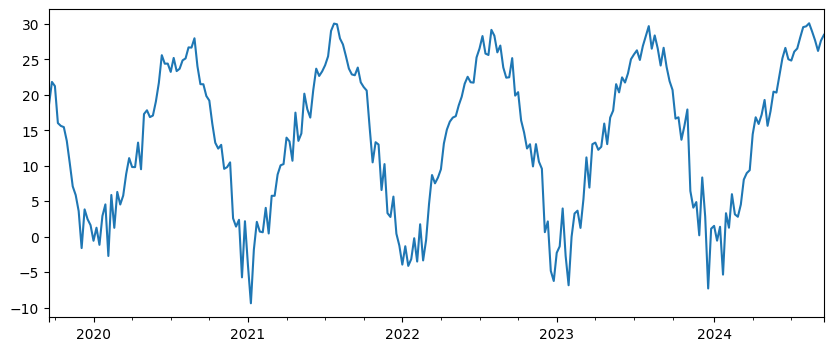

In [ ]:
# 날짜 주기(frequency)를 명시적으로 지정해 경고 제거
ts.index = pd.to_datetime(ts.index, format='%Y-%m-%d')
ts = ts.asfreq('W')  # 주별 데이터로 주기 설정
ts.plot(figsize=(10,4)) #시각화

###모델 학습

파라미터 설정을 통해 계절 패턴을 적절히 반영할 수 있도록 해야 합니다.
seasonal, m(계절주기) 등을 활용해 계절성을 반영해봅시다.

- 우선, auto_arima를 사용하기 위해 pmdarima를 설치해야 합니다.

In [ ]:
!pip install pmdarima -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00


!pip install 명령어에 -q 옵션을 추가하여 조용한(quiet) 모드로 실행할 수 있습니다.

**-q 옵션은 불필요한 출력 메시지를 줄여줍니다.**

- train_data가 아닌, ts(전체데이터)로 auto_arima 모델에 적합하는 이유?

    - 일반적으로 모델 학습 전에 데이터를 훈련 데이터와 테스트 데이터로 분할하는 것이 맞습니다.
    - 하지만 AutoARIMA의 경우, 먼저 전체 데이터를 사용하여 최적의 p,d,q를 찾고, 그 다음에 훈련 데이터를 기반으로 모델을 다시 학습하는 과정을 진행할 수 있습니다.
    - 즉, AutoARIMA가 **전체 데이터에서 차수 선택을 자동으로 최적화**하는 데 필요한 정보를 얻고, 그 후 실제로 예측할 때는 훈련 데이터만 사용합니다.

- 하기 코드 소요시간 12-13분

In [ ]:
%%time

from pmdarima import auto_arima

auto_arima_model = auto_arima(
    ts,
    seasonal=True,             # 계절성 모델 적용
    m=52,                      # 주간 데이터에서는 계절 주기를 52로 설정 (1년 = 52주)
    stepwise=True,             # 단계별 탐색으로 빠른 계산
    trace=True,                # 모델 피팅 과정 출력
    error_action='ignore',     # 모델 피팅 중 에러 무시
    suppress_warnings=True,    # 경고 메시지 숨김
    max_order=10,              # 최대 차수 제한
    start_p=1, start_q=1,      # p와 q의 초기 값
    max_p=3, max_q=3,          # p와 q의 최대 값
    start_P=0, start_Q=0,      # 계절적 P와 Q의 초기 값
    max_P=2, max_Q=2,          # 계절적 P와 Q의 최대 값
    d=None, D=1,               # 차분(d)은 자동 선택, 계절 차분(D)은 1
)

auto_arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1081.270, Time=8.29 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1087.400, Time=0.30 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1043.424, Time=6.61 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1045.637, Time=10.54 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1086.813, Time=0.23 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1082.527, Time=0.88 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=1045.395, Time=32.55 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=1045.275, Time=15.63 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=1045.817, Time=10.70 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=inf, Time=157.24 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1049.353, Time=4.28 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=1045.387, Time=13.77 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=1043.852, Time=18.13 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=1043.202, Time=10.46 sec
 ARIMA(0,0,1)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  262
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood                -517.601
Date:                             Thu, 03 Oct 2024   AIC                           1043.202
Time:                                     14:56:24   BIC                           1056.591
Sample:                                 09-22-2019   HQIC                          1048.615
                                      - 09-22-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3946      0.257      1.535      0.125      -0.109       0.899
ma.L1          0.2062      0.060      3.431      0.001       0.088       0.324
ar.S.L52      -0.4947      0.059     -8.370      0.000      -0.611      -0.379
sigma2         7.5530      0.736     10.256      0.000       6.110       8.996
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.96   Prob(JB):                         0.83
Heteroskedasticity (H):               0.95   Skew:                            -0.06
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###훈련,평가데이터 분할

In [ ]:
# 전체 데이터의 길이 확인
total_len = len(ts)

# 80:20 비율로 훈련/평가 데이터 분할
train_size_n = int(total_len * 0.8)
train_data = ts[:train_size_n]
test_data = ts[train_size_n:]

print(total_len, len(train_data), len(test_data))

262 209 53


###훈련데이터로 학습

In [ ]:
auto_arima_model.fit(train_data)

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 0, 52),
      suppress_warnings=True)

###예측

In [ ]:
forecast = auto_arima_model.predict(n_periods=len(test_data))
forecast.tail()

,0
2024-08-25,25.331854
2024-09-01,23.421246
2024-09-08,24.637598
2024-09-15,24.775137
2024-09-22,20.467725


###성능확인

- 지난번에 구현한 get_metrics()로 모델의 성능을 확인해봅시다.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def get_metrics(test_data, forecast):
    # MSE (Mean Squared Error) 계산
    mse = mean_squared_error(test_data, forecast)
    print(f'MSE: {mse:.3f}')

    # RMSE (Root Mean Squared Error) 계산
    rmse = np.sqrt(mse)
    print(f'RMSE: {rmse:.3f}')

    # MAPE (Mean Absolute Percentage Error) 계산 (분모가 0인 경우 무시)
    epsilon = 1e-10  # 0으로 나누면 분모에 0이 들어가면서 inf 또는 NaN이 발생할 수 있음.
    #이를 방지하기 위해 작은 값 추가!
    mape = np.mean(np.abs((test_data - forecast) / (test_data + epsilon))) * 100
    print(f'MAPE: {mape:.3f}%')

get_metrics(test_data, forecast)

MSE: 9.641
RMSE: 3.105
MAPE: 63.579%


- 지난시간 SARIMA 성능지표
    - MSE: 9.819
    - RMSE: 3.134
    - MAPE: 55.107%
- SARIMA와 비교했을 때 Auto-arima모델의 MSE, RMSE는 소폭 개선되고 MAPE는 오히려 증가했음을 알 수 있습니다.

###잔차분석

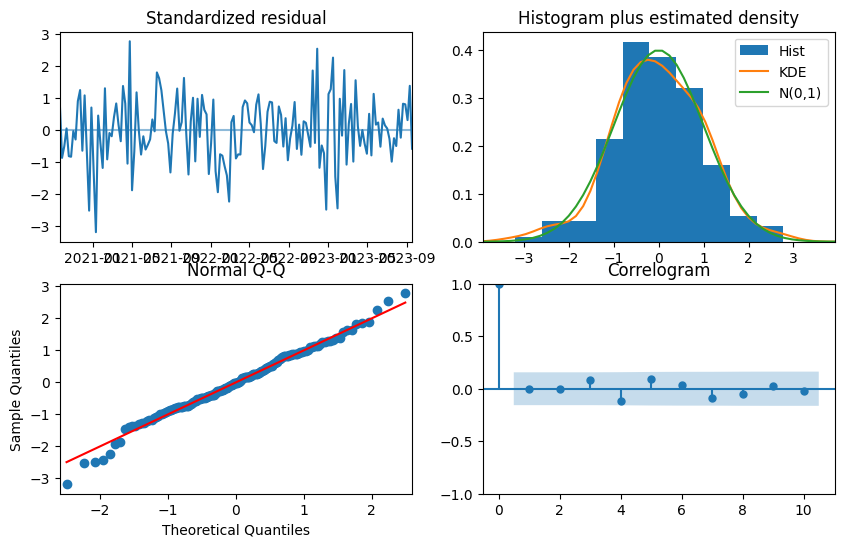

In [ ]:
import matplotlib.pyplot as plt

auto_arima_model.plot_diagnostics(figsize=(10, 6))
plt.show()

- Standardized Residuals
    - 시간에 따른 모델의 잔차를 시각화
    - 잔차가 일정한 패턴 없이 평균 0을 중심으로 무작위로 분포해 있다면, 모델이 데이터에 잘 적합된 것입니다.
    - 이 그래프에서는 잔차가 평균 0을 중심으로 일정한 패턴 없이 분포하고 있어, 모델이 데이터에 전반적으로 잘 맞고 있다고 볼 수 있습니다.
    - 하지만 일부잔차가 -3~3 사이 극단 값을 가지며 이는 특정 시점에서 모델이 데이터의 변동성을 충분히 설명하지 못함의 의미합니다.

- Histogram + Estimated Density
    - 잔차가 정규 분포를 따르는지를 확인하기 위한 히스토그램과 밀도 함수
    - 초록색 선은 N(0,1)정규분포를 나타내고, 주황색 선은 잔차의 추정밀도입니다.
    - 잔차가 완벽하게 정규성을 띄지않지만 대체로 정상성에 가까운 분포를 따릅니다.

- Normal Q-Q 플롯
    - 잔차가 정규 분포를 따르는지를 시각적으로 평가하기 위한 플롯입니다. 점들이 빨간색 직선에 가까울수록 잔차가 정규성을 만족한다는 뜻입니다.
    - 대다수의 점이 빨간색 직선 근처에 위치해 있으며, 이는 잔차가 전반적으로 정규성을 만족하고 있음을 보여줍니다.
    - 그러나 **양 끝단에서 일부 점들이 직선에서 벗어나는 모습**을 보여주고 있으며, 이는 극단적인 이상치가 존재할 수 있음을 시사합니다. 잔차의 비정규성은 모델이 데이터의 모든 패턴을 충분히 설명하지 못할 가능성을 나타냅니다.

- Correlogram(잔차의 자기상관도)
    - 잔차의 자기 상관 관계를 시각적으로 나타낸 플롯입니다. 잔차가 무작위로 분포하고 자기 상관성이 없다면, 모델이 데이터를 잘 설명했다고 할 수 있습니다.
    - 대부분의 지점에서 잔차의 자기 상관성이 0에 가깝고, 이는 모델이 데이터 패턴을 잘 설명하고 있음을 나타냅니다.

###잔차 자기상관성 확인

- 잔차: 예측된 값과 실제 값의 차이

In [ ]:
###잔차계산
residuals = test_data - forecast
residuals.tail()

,0
2024-08-25,3.611003
2024-09-01,4.278754
2024-09-08,1.562402
2024-09-15,2.896292
2024-09-22,8.007275


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box 검정 (잔차의 독립성 검정)
ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True) #10번째 지연(lag)까지 잔차의 자기상관성을 확인
print(ljung_box_test)

     lb_stat  lb_pvalue
10  3.997005   0.947482


p-값이 0.05보다 크기 때문에, 잔차에 자기상관성이 없다는 귀무가설을 기각하지 못합니다. 즉, 잔차는 독립적이며, **모델이 데이터를 잘 설명하고 있다**고 볼 수 있습니다.

###예측 시각화

지난시간에 구현한 get_figure()함수로 예측결과를 시각화해봅시다.

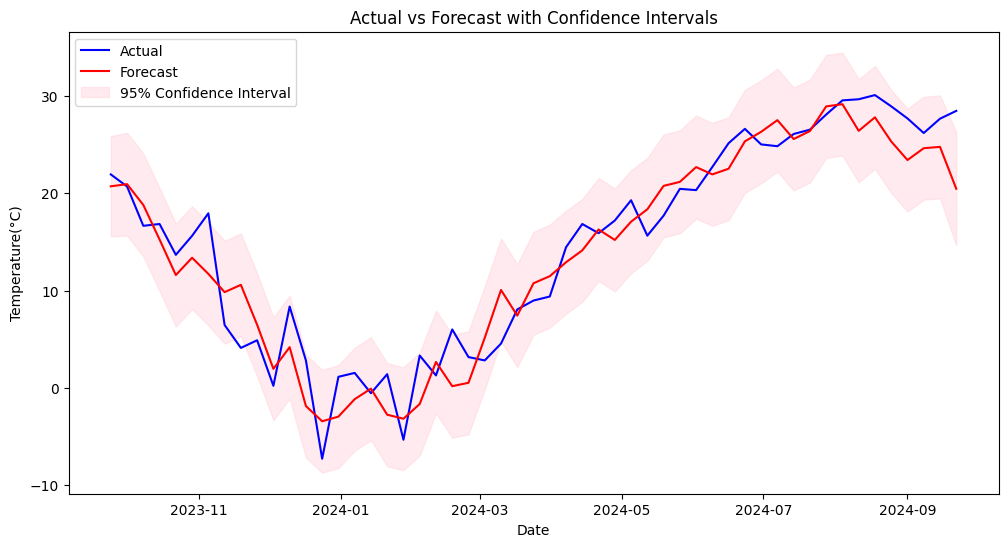

In [ ]:
# 시각화

def get_figure(test_data, forecast,conf_int):
    plt.figure(figsize=(12, 6))

    # 실제값
    plt.plot(test_data.index, test_data, label='Actual', color='blue')

    # 예측값
    plt.plot(test_data.index, forecast, label='Forecast', color='red')

    # 신뢰구간
    plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

    plt.title('Actual vs Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Temperature(°C)')
    plt.legend()
    plt.show()

# AutoARIMA 모델로 예측과 신뢰구간 계산
forecast, conf_int = auto_arima_model.predict(n_periods=len(test_data), return_conf_int=True)
# conf_int를 DataFrame으로 변환(신뢰구간 하한선과 상한선!)
conf_int = pd.DataFrame(conf_int, index=test_data.index, columns=['Lower', 'Upper'])

get_figure(test_data, forecast,conf_int)

###결론

AutoARIMA 모델의 예측 결과(빨간선)가 SARIMA 모델에 비해 실제 값(파란선)에 더 근접함을 확인할 수 있었습니다. 이는 AutoARIMA가 데이터를 자동으로 분석하여 최적의 파라미터를 선택하고, 계절성을 포함하지 않은 시계열 데이터에 특히 유용한 모델임을 보여줍니다.

하지만, AutoARIMA는 복잡한 계절성과 비선형 패턴을 충분히 반영하지 못할 수 있습니다. 이를 보완하기 위해 이제 Prophet 모델을 사용하여 예측을 수행해 보겠습니다. Prophet은 Facebook에서 개발한 모델로, 계절성과 추세를 자동으로 처리하며, 특히 비선형적인 시계열 데이터를 다루는 데 강점을 보입니다.

Prophet 모델을 통해 학습 및 예측을 진행한 후, AutoARIMA와 Prophet의 성능을 비교 분석해보겠습니다.

# 모델2.Prophet

In [ ]:
import os
os.getcwd()

'/content'

###데이터 로드

In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/스코/ta_20240920220735.csv'

# CSV 파일을 8행부터 읽어오기 (skiprows=7)
df = pd.read_csv(file_path, skiprows=6,
                 encoding='CP949',
                #  index_col=0, #날짜열을 인덱스로 지정해야합니다!
                 parse_dates=True
                 )
df.index.name = None #인덱스명 제거
ts = df.iloc[-1825:, [0,2]] #'평균기온' 컬럼만 선택, 최근 약 5년치 데이터만 선택
ts

,날짜,평균기온(℃)
7204,\t2019-09-22,18.6
7205,\t2019-09-23,20.0
7206,\t2019-09-24,19.8
7207,\t2019-09-25,20.9
7208,\t2019-09-26,22.9
...,...,...
9024,\t2024-09-15,27.5
9025,\t2024-09-16,26.8
9026,\t2024-09-17,28.6
9027,\t2024-09-18,29.4


### 전처리
####컬럼명 수정

- 페이스북의 예측 라이브러리가 작동하는 방식은, **데이터셋의 열 부분이 ds와 y로 지정**되어 있어야 합니다.
- 날짜열이 ds, 예측하려는 데이터 레이블은 y로 컬럼명 수정

In [ ]:
ts.columns = ['ds', 'y']
ts['ds'] = ts['ds'].str[1:]
ts

,ds,y
7204,2019-09-22,18.6
7205,2019-09-23,20.0
7206,2019-09-24,19.8
7207,2019-09-25,20.9
7208,2019-09-26,22.9
...,...,...
9024,2024-09-15,27.5
9025,2024-09-16,26.8
9026,2024-09-17,28.6
9027,2024-09-18,29.4


####문자열 제거

####datetime 형변환

ds 컬럼 datetime으로 형변환

In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 7204 to 9028
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      1825 non-null   object 
 1   y       1825 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.6+ KB


In [ ]:
ts['ds'] = pd.to_datetime(ts['ds'])
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 7204 to 9028
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1825 non-null   datetime64[ns]
 1   y       1825 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.6 KB


###주간데이터로 변환

In [ ]:
# 주간별 평균 기온 계산
ts = ts.resample('W-Sun', on='ds').mean().reset_index()
ts

,ds,y
0,2019-09-22,18.600000
1,2019-09-29,21.828571
2,2019-10-06,21.242857
3,2019-10-13,16.028571
4,2019-10-20,15.628571
...,...,...
257,2024-08-25,28.942857
258,2024-09-01,27.700000
259,2024-09-08,26.200000
260,2024-09-15,27.671429


In [ ]:
ts.to_csv('./weather.csv')

###시각화

<Axes: xlabel='ds'>

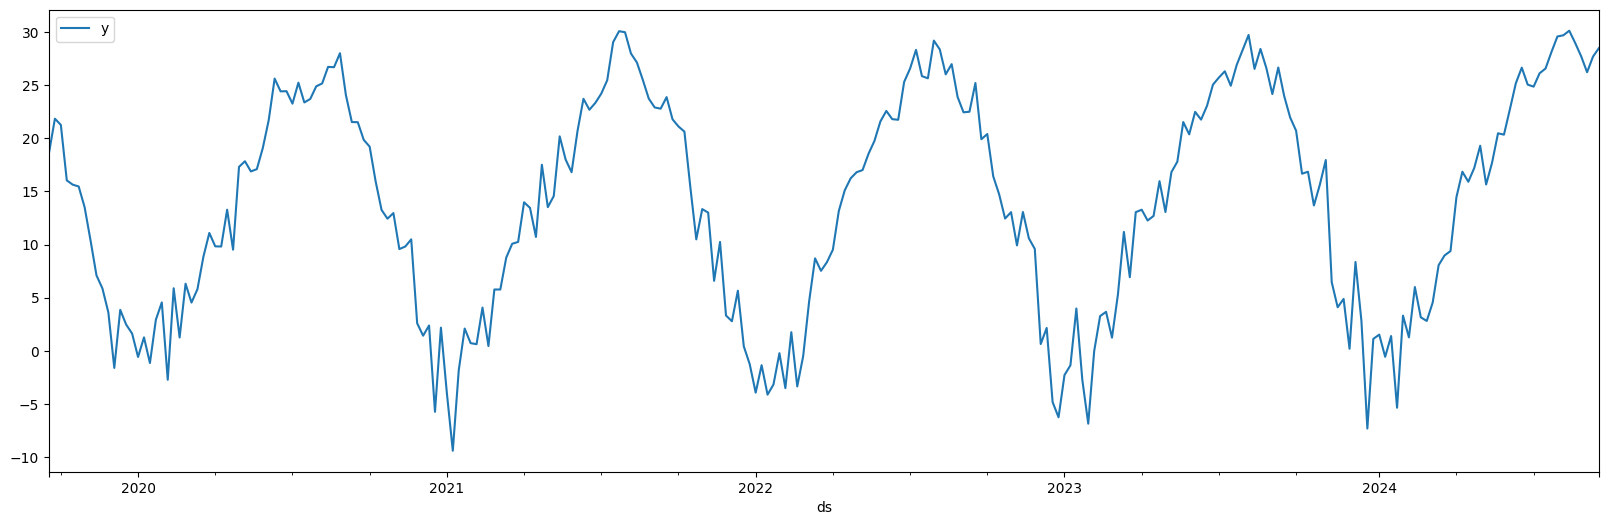

In [ ]:
ts.plot(x='ds', y='y', figsize=(20,6))

- 매년 여름에 기온이 상승하고, 겨울에 기온이 하락하는 계절적인 변화를 확인
- 계절성은 Prophet 모델이 잘 처리할 수 있는 부분입니다. 연간 주기적인 패턴을 예측하는 모델을 구현해봅시다.

In [ ]:
# !pip install --upgrade plotly

In [ ]:
!pip install prophet

### 학습, 평가데이터 분할

In [ ]:
# 전체 데이터의 길이 확인
total_len = len(ts)

# 80:20 비율로 훈련/평가 데이터 분할
train_size_n = int(total_len * 0.8)
train_data = ts[:train_size_n]
test_data = ts[train_size_n:]

print(total_len, len(train_data), len(test_data))

262 209 53


- 전체 데이터셋을 80:20 비율로 훈련 데이터(train)와 평가 데이터(test)로 나눕니다.
   - 이 경우, 약 5년치 데이터를 사용했으며, 훈련 데이터는 약 4년치, 평가 데이터는 약 1년치로 설정됩니다.
   - Prophet은 훈련 데이터를 기반으로 패턴을 학습한 뒤, 평가 데이터를 예측하게 됩니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

%matplotlib inline

###모델 학습

In [ ]:
#계절성 모드는 곱셈 모델을 사용해야 시간에 따라 증가하는 것을 학습가능
m = Prophet(changepoint_prior_scale=0.1,
            yearly_seasonality=True)#seasonality_mode='multiplicative')
m.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt1y394h1/zlow0w1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt1y394h1/hk0zhniu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88453', 'data', 'file=/tmp/tmpt1y394h1/zlow0w1m.json', 'init=/tmp/tmpt1y394h1/hk0zhniu.json', 'output', 'file=/tmp/tmpt1y394h1/prophet_modell2wfceg5/prophet_model-20241003150351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:03:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


예측 모델을 보면, 많은 매개변수를 보실 수 있고 연간 계절성, 주간 계절성 등 매개변수들이 자동적으로 선택된 것을 볼 수 있습니다.

#### 계절성 반영

- 현재는 `additive` (기본값) 모드로 모델링합니다.
    - 만약 기온이 시간이 지나면서 계절성이 더 증폭되는 패턴이 보인다면, 곱셈 모드를 고려할 수 있습니다.
    - 최근 5년간 기온 변동폭이 일정하게 유지되므로 기본형인 additive 모드를 사용합니다. 즉, 계절성 패턴이 시간이 지남에 따라 일정한 크기로 변동하는 경우에는 additive 모드가 적합합니다.
    
- 그 외에도 Prophet 정의 시 다양한 파라미터가 있습니다.
    - **seasonality_mode**
        - 'additive' 또는 'multiplicative'로 계절성을 설정합니다. multiplicative는 데이터의 변동성이 시간이 지남에 따라 더 커지거나 작아지는 경우에 사용합니다.
        - Prophet에서 기본적으로 계절성을 자동으로 학습하지만, 계절성이 뚜렷하고 그 변동폭이 시간에 따라 비례적으로 커지거나 작아지는 경우 곱셈 모드를 사용하는 것이 적합합니다.
        - 예를 들어, 기온 데이터가 시간이 지남에 따라 계절적인 기온 차이가 더 크게 벌어지면 곱셈 모드가 유용할 수 있습니다.

    - **changepoint_prior_scale**
        - 추세 변화점(Changepoints)에 대한 민감도를 조정하는 파라미터입니다. 기본값은 0.05로, 값이 클수록 모델이 더 민감하게 추세 변화를 감지합니다. 만약 기온 데이터에서 큰 변동이 적다면, 이 값을 더 낮출 수 있습니다.

    - **yearly_seasonality**
        - 연간 계절성을 학습할지를 설정합니다. Prophet은 데이터의 길이에 따라 자동으로 이를 감지하지만, 계절성을 강제로 적용하거나 해제할 수도 있습니다. 예를 들어, yearly_seasonality=True로 설정하면 연간 주기 패턴을 강제할 수 있습니다.

    - **holidays**
        - 휴일 데이터를 추가할 수 있습니다. 휴일이 기온에 영향을 미친다고 생각된다면, 특정 휴일에 대해 기온의 변화 패턴을 학습시킬 수 있습니다.



###모델 예측

In [ ]:
future = m.make_future_dataframe(periods=52, freq='W')  # freq='W'로 주간 데이터 생성
future

,ds
0,2019-09-22
1,2019-09-29
2,2019-10-06
3,2019-10-13
4,2019-10-20
...,...
256,2024-08-18
257,2024-08-25
258,2024-09-01
259,2024-09-08


`make_future_dataframe()`을 사용하여 예측할 기간을 설정합니다.
- 여기서는 평가 데이터의 길이만큼 미래 데이터를 예측합니다.

In [ ]:
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-22,13.592080,19.285424,24.723675,13.592080,13.592080,8.459562,8.459562,8.459562,8.459562,8.459562,8.459562,0.0,0.0,0.0,22.051642
1,2019-09-29,13.589608,18.197522,23.538394,13.589608,13.589608,7.370176,7.370176,7.370176,7.370176,7.370176,7.370176,0.0,0.0,0.0,20.959784
2,2019-10-06,13.587136,16.359286,21.774059,13.587136,13.587136,5.538771,5.538771,5.538771,5.538771,5.538771,5.538771,0.0,0.0,0.0,19.125907
3,2019-10-13,13.584663,14.072349,19.504371,13.584663,13.584663,3.105066,3.105066,3.105066,3.105066,3.105066,3.105066,0.0,0.0,0.0,16.689729
4,2019-10-20,13.582191,11.418184,17.170076,13.582191,13.582191,0.765023,0.765023,0.765023,0.765023,0.765023,0.765023,0.0,0.0,0.0,14.347214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2024-08-18,14.470255,24.652165,30.305855,14.425494,14.514971,13.065453,13.065453,13.065453,13.065453,13.065453,13.065453,0.0,0.0,0.0,27.535708
257,2024-08-25,14.477589,23.686831,29.128646,14.431189,14.523785,12.065697,12.065697,12.065697,12.065697,12.065697,12.065697,0.0,0.0,0.0,26.543286
258,2024-09-01,14.484922,22.783381,28.152678,14.436854,14.532876,10.935239,10.935239,10.935239,10.935239,10.935239,10.935239,0.0,0.0,0.0,25.420161
259,2024-09-08,14.492256,21.596856,27.025567,14.443420,14.541800,9.908772,9.908772,9.908772,9.908772,9.908772,9.908772,0.0,0.0,0.0,24.401028


- forecast는 예측된 값들과 그에 해당하는 신뢰 구간을 포함하는 데이터프레임입니다.
- yhat은 예측된 기온 값이며, yhat_lower와 yhat_upper는 95% 신뢰 구간을 의미합니다. 즉, 예측된 값의 **불확실성**을 보여주는 값들입니다.

In [ ]:
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2019-09-22,19.285424,24.723675,22.051642
1,2019-09-29,18.197522,23.538394,20.959784
2,2019-10-06,16.359286,21.774059,19.125907
3,2019-10-13,14.072349,19.504371,16.689729
4,2019-10-20,11.418184,17.170076,14.347214
...,...,...,...,...
256,2024-08-18,24.652165,30.305855,27.535708
257,2024-08-25,23.686831,29.128646,26.543286
258,2024-09-01,22.783381,28.152678,25.420161
259,2024-09-08,21.596856,27.025567,24.401028


예측 결과에서 날짜, 예측값, 신뢰 구간(하한/상한)만 선택

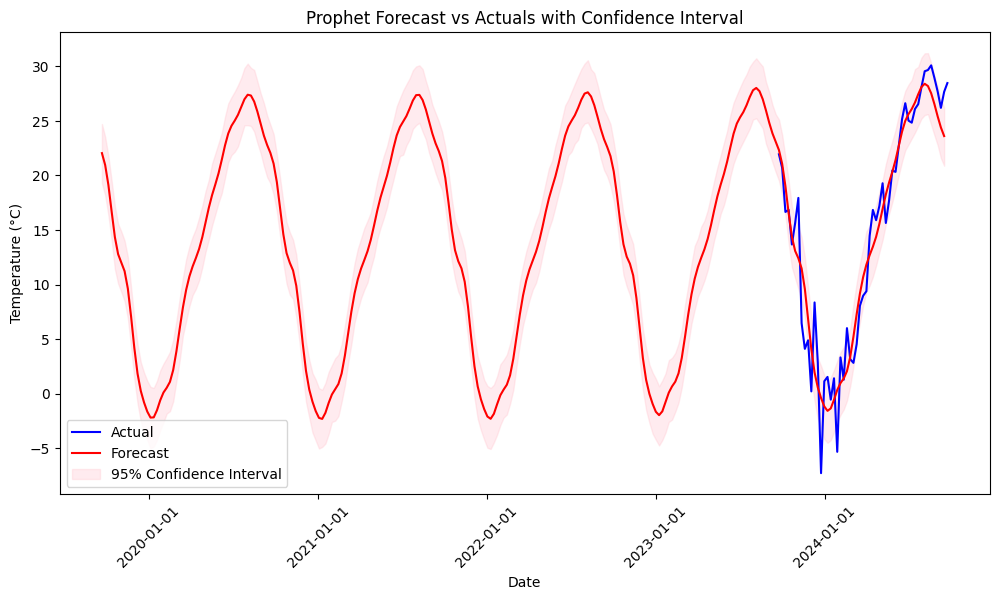

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prophet 예측 시각화 (SARIMA 스타일에 맞게 수정)
plt.figure(figsize=(12, 6))

# 실제 값 (Actual)
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')

# 예측 값 (Forecast)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

# 신뢰 구간 (Confidence Interval)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3, label='95% Confidence Interval')

# 그래프 설정
plt.title('Prophet Forecast vs Actuals with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# X축 레이블 각도 조정
plt.xticks(rotation=45)

# 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 그래프 출력
plt.show()

- **ax=ax**: 예측 그래프 위에 실제 데이터를 추가하여 두 그래프를 겹쳐서 비교할 수 있습니다.
- **xlim**: X축의 날짜 범위를 설정해 원하는 구간만을 확대해서 볼 수 있습니다.
- **mdates.date2num(forecast['ds'])**: `fill_between` 함수에서 날짜 데이터를 숫자로 변환해 `matplotlib`가 날짜를 적절히 처리하도록 합니다.
- **ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))**: X축의 날짜 형식을 사람이 읽을 수 있는 '년-월-일' 형식으로 설정합니다.

####예측 시각화 해석
- Predictions: Prophet 모델이 예측한 값(기온)을 나타냅니다. 이 선은 Prophet이 학습한 데이터 패턴(계절성, 추세)을 바탕으로 미래 기온을 예측한 결과입니다.
- 신뢰구간: Prophet 모델의 예측값에 대한 95% 신뢰구간. 이 구간은 Prophet이 예측한 값이 얼마나 불확실한지를 나타내며, 모델이 예측한 값이 이 범위 내에 있을 확률이 95%임을 의미합니다.

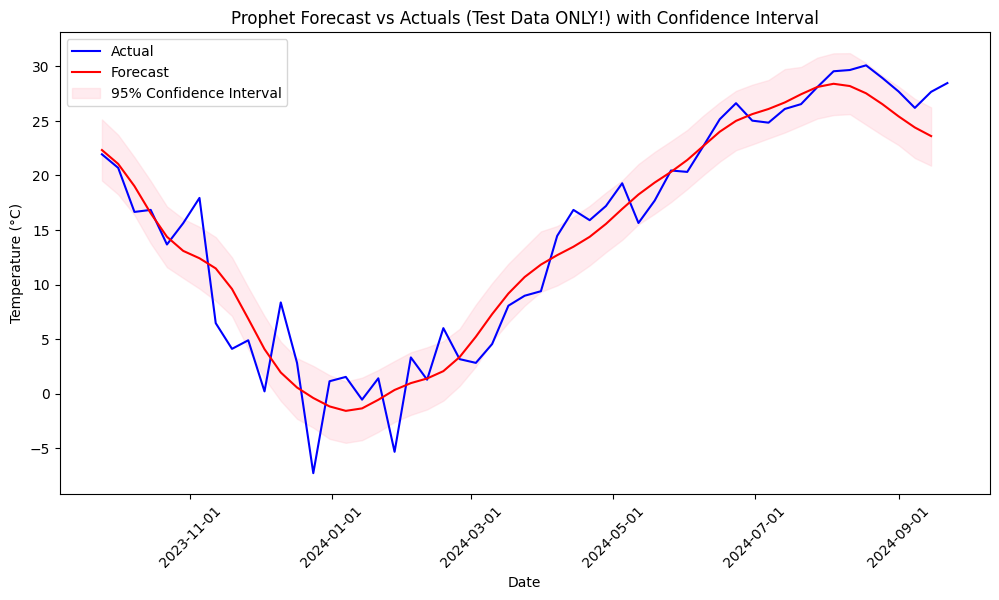

In [ ]:
# 평가데이터 기간(최근1년)만 시각화해보기!

# 테스트 데이터 구간에 해당하는 Prophet 예측 결과 필터링
forecast_test = forecast[forecast['ds'].isin(test_data['ds'])]

# Prophet 예측 시각화 (SARIMA 스타일에 맞게 수정)
plt.figure(figsize=(12, 6))

# 실제 값 (Actual)
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')

# 예측 값 (Forecast)
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='red')

# 신뢰 구간 (Confidence Interval)
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='pink', alpha=0.3, label='95% Confidence Interval')

# 그래프 설정
plt.title('Prophet Forecast vs Actuals (Test Data ONLY!) with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# X축 레이블 각도 조정
plt.xticks(rotation=45)

# 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 그래프 출력
plt.show()

####SARIMA 모델과 Prophet 예측선 비교

Prophet 모델의 예측선이 SARIMA 모델에 비해 더 매끄럽게 나타나는 것을 볼 수 있습니다. 이는 Prophet이 데이터의 추세와 계절성을 효과적으로 분리하여 반영한 결과입니다. Prophet은 비선형적 변화와 계절성을 자동으로 감지하고 적응하기 때문에, 데이터의 복잡한 패턴을 더 자연스럽게 학습하고 있습니다.

반면 SARIMA는 선형 패턴을 주로 반영하는데, 특정 시점에서의 변동을 잘 설명하지 못하는 경향이 있습니다. Prophet의 예측선이 더 매끄럽다는 것은 과소적합을 피하면서, 복잡한 계절성과 트렌드를 더 잘 반영한 결과로 볼 수 있으며, 이는 모델의 일반화 성능이 뛰어남을 보여줍니다~!

###추세 시각화

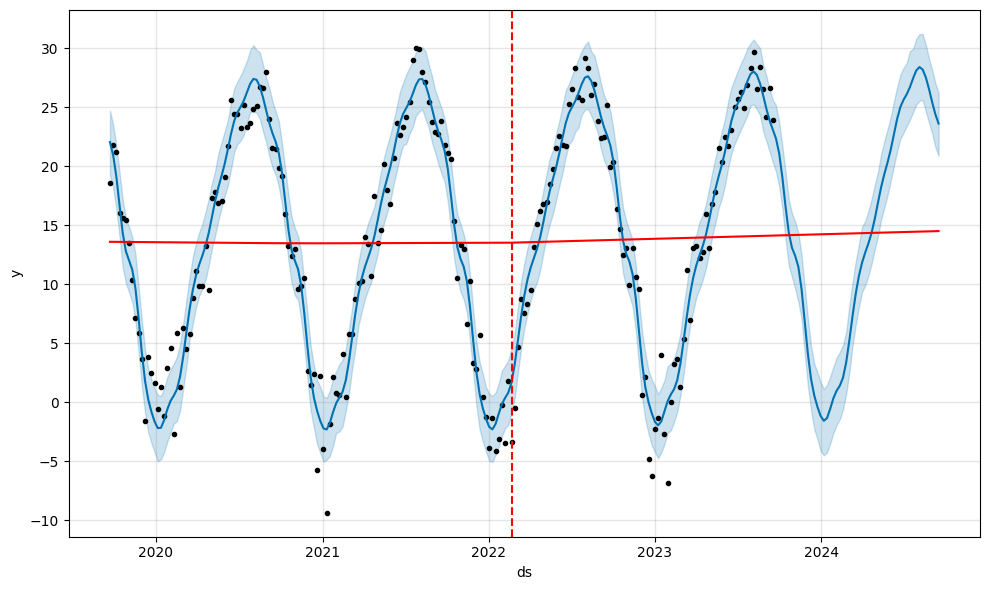

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)

#변수명이 a인 이유: 공식문서 참조
a = add_changepoints_to_plot(fig.gca(),m,forecast) #현재모델의 축과 모델, 예측결과
# add_changepoints_to_plot(fig.gca(),m,forecast)

#### add_changepoints_to_plot

- 이 코드는 Prophet 모델이 감지한 **변화점(Changepoints)**을 그래프에 표시하는 역할을 합니다. Prophet은 데이터에서 추세가 급격히 변하는 시점을 자동으로 감지하며, 이를 **변화점**이라고 부릅니다.

- 그래프에 표시된 여러 **빨간 수직선**
    - Prophet이 민감하게 추세 변화를 탐지한 결과
    - **changepoint_prior_scale** 파라미터 값
        - 변화점이 많다고 해서 반드시 큰 추세 변화가 있는 것은 아닙니다. Prophet은 설정된 민감도에 따라 작은 변화도 감지할 수 있는데, changepoint_prior_scale 파라미터 값 굵은 텍스트을 조정하면 추세 변화 감지 민감도를 줄일 수 있습니다.

- **계절성**이 데이터의 주요 패턴을 형성
    - 즉, 계절적인 변동이 주된 특징이며, 추세 변화는 상대적으로 작습니다. 따라서 변화점의 수가 많더라도, 추세 자체에 큰 변화가 없는 경우도 있을 수 있습니다.

- 그래프에서 **수평선이 조금씩 올라가는 현상**
    - Prophet이 감지한 **장기적인 추세(Trend)**를 의미합니다.
    - 이는 시간이 지남에 따라 **기온이 미세하게 상승**하고 있음을 시사합니다. Prophet 모델은 **추세와 계절성**을 분리하여 분석하기 때문에, 계절적인 변동과 별개로 데이터가 장기적으로 상승하거나 하락하는지 확인할 수 있습니다.


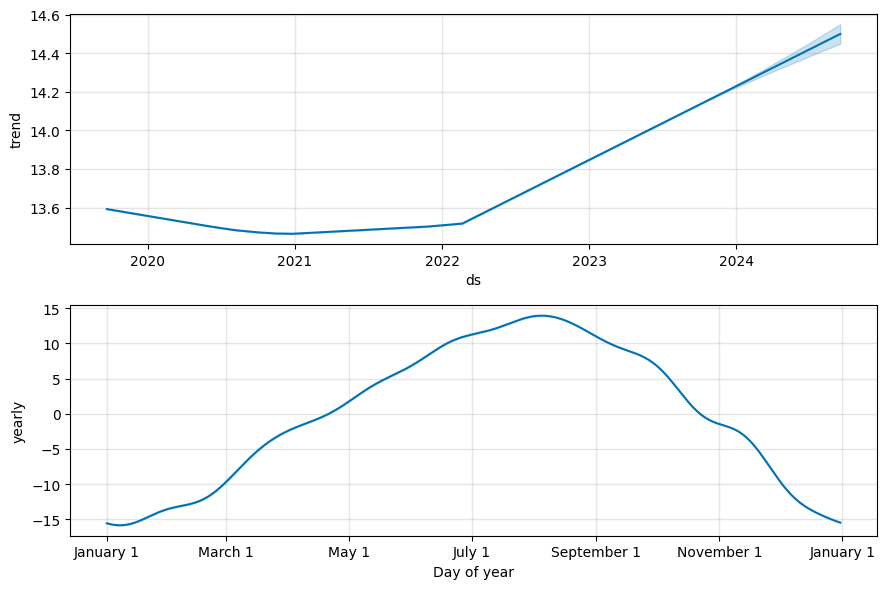

In [ ]:
m.plot_components(forecast); #추세선과 연간계절성 시각화

####plot_components

이 함수는 Prophet 모델이 분석한 추세와 계절성을 개별적으로 시각화합니다. Prophet은 데이터를 추세와 계절성으로 분리하여 예측을 수행하므로, 이 그래프들은 모델이 각 요소를 어떻게 분석하고 있는지 보여줍니다.

- 추세(Trend)
    - 이 그래프에서 보이는 상승 추세는 **시간이 지남에 따라 기온이 장기적으로 상승하고 있음**을 나타냅니다.
    - 이 그래프를 add_changepoints_to_plot의 결과와 연결해보면, 빨간색 수직선이 표시된 구간이 바로 이 추세가 변하는 중요한 시점들임을 알 수 있습니다. Prophet은 이 변화를 감지하여 모델에 반영하고 있습니다.
- 연간 계절성(Yearly Seasonality)
    - 1월에 기온이 가장 낮고, 8월에 기온이 최고점을 찍는 전형적인 기온 변동 패턴을 보여줍니다. 이 **계절성은 기온 데이터의 주요 패턴** 중 하나로, Prophet 모델이 이 정보를 학습하여 정확한 예측을 도출하는 데 기여합니다.

앞서 확인했던 add_changepoints_to_plot에서 감지된 **변화점**과 함께 이 연간 계절성 그래프를 보면, 추세와 계절성이 서로 어떻게 조화를 이루며 모델의 예측에 영향을 미치는지 알 수 있습니다.

Prophet 모델을 통해 우리는 데이터를 단순히 예측하는 것 이상의 정보를 얻을 수 있습니다.

add_changepoints_to_plot 함수는 데이터를 분석할 때 Prophet이 **어디에서 추세 변화를 감지**했는지를 시각적으로 보여주며, plot_components 함수는 **추세와 계절성을 분리하여 각각의 패턴**을 명확히 분석하는 데 도움을 줍니다.



###잔차분석

- 잔차 분석을 통해, 모델이 예측하지 못한 변동성을 파악하고, 이를 시각화하여 더 명확히 평가할 수 있습니다.

- **예측된 값과 실제 값 사이의 차이**인 잔차(residual)는 모델이 정확하게 추세와 계절성을 반영하고 있는지 확인하는 데 필수적입니다.

- 하지만 Prophet 모델은 ARIMA와 달리 자동으로 잔차를 계산하고 분석하는 기능을 기본 제공하지 않습니다. 따라서, Prophet을 사용한 잔차분석은 수동으로 계산해야 합니다.

In [ ]:
# ts와 forecast 데이터를 날짜를 기준으로 병합
# 원래데이터인 ts에 예측값인 yhat을 ds기준(조인 기준)으로 inner 조인하기
merged_data = pd.merge(ts[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
merged_data

,ds,y,yhat
0,2019-09-22,18.600000,22.051642
1,2019-09-29,21.828571,20.959784
2,2019-10-06,21.242857,19.125907
3,2019-10-13,16.028571,16.689729
4,2019-10-20,15.628571,14.347214
...,...,...,...
256,2024-08-18,30.100000,27.535708
257,2024-08-25,28.942857,26.543286
258,2024-09-01,27.700000,25.420161
259,2024-09-08,26.200000,24.401028


####잔차 계산

Prophet에서 예측 값(yhat)과 실제 값(y) 간의 차이를 직접 계산해 잔차를 구합니다.

In [ ]:
# 잔차 계산!
merged_data['residual'] = merged_data['y'] - merged_data['yhat']
merged_data

,ds,y,yhat,residual
0,2019-09-22,18.600000,22.051642,-3.451642
1,2019-09-29,21.828571,20.959784,0.868787
2,2019-10-06,21.242857,19.125907,2.116950
3,2019-10-13,16.028571,16.689729,-0.661158
4,2019-10-20,15.628571,14.347214,1.281358
...,...,...,...,...
256,2024-08-18,30.100000,27.535708,2.564292
257,2024-08-25,28.942857,26.543286,2.399572
258,2024-09-01,27.700000,25.420161,2.279839
259,2024-09-08,26.200000,24.401028,1.798972


####잔차 시각화

- 잔차를 그래프로 시각화하여 모델이 실제 데이터와 얼마나 차이가 나는지 확인해봅시다.

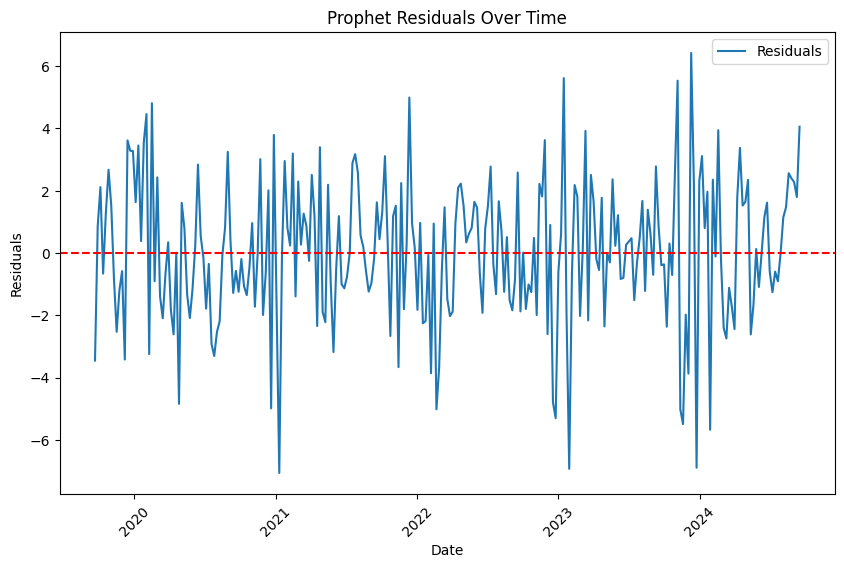

In [ ]:
# ts와 forecast 데이터를 날짜를 기준으로 병합
merged_data = pd.merge(ts[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# 잔차 계산
merged_data['residual'] = merged_data['y'] - merged_data['yhat']

# 잔차 시각화
plt.figure(figsize=(10,6))
plt.plot(merged_data['ds'], merged_data['residual'], label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Prophet Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)
plt.legend()
plt.show()


####잔차분포확인

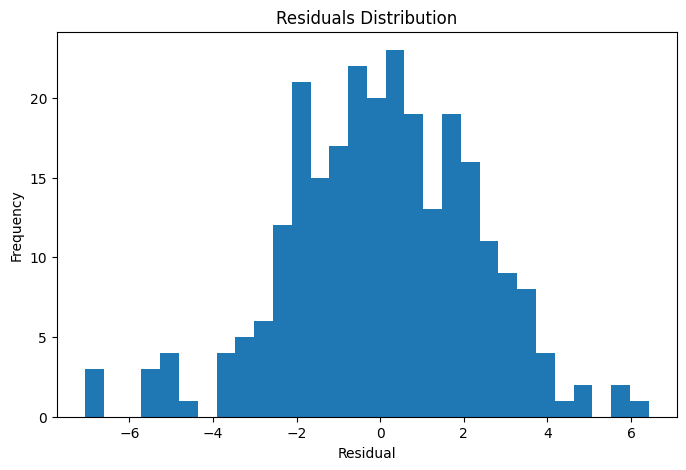

In [ ]:
# 잔차 히스토그램
plt.figure(figsize=(8,5))
plt.hist(merged_data['residual'], bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


####잔차 자기상관성 확인: Ljung-box Test

Ljung-Box 테스트는 잔차에 자기 상관이 있는지 확인하는 검정입니다. 잔차가 백색잡음(부작위적)이어야 좋은 모델인데, 잔차에 자기상관이 남아있는지 즉 모델이 모든 패턴을 설명하짐 못하고 예측에 남은 정보가 있는지 확인합니다.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box 테스트
ljung_test = acorr_ljungbox(merged_data['residual'], lags=[10], return_df=True)
print(ljung_test)

      lb_stat  lb_pvalue
10  10.462624   0.400885


현재 Ljung-Box 테스트 결과에서 p-value가 0.05보다 큽니다.(0.4) 따라서 모델의 잔차가 무작위(백색소음)임을 알 수 있습니다.



###성능확인

get_metrics()를 통해 성능지표를 확인해봅시다.

In [ ]:
merged_data

,ds,y,yhat,residual
0,2019-09-22,18.600000,22.051642,-3.451642
1,2019-09-29,21.828571,20.959784,0.868787
2,2019-10-06,21.242857,19.125907,2.116950
3,2019-10-13,16.028571,16.689729,-0.661158
4,2019-10-20,15.628571,14.347214,1.281358
...,...,...,...,...
256,2024-08-18,30.100000,27.535708,2.564292
257,2024-08-25,28.942857,26.543286,2.399572
258,2024-09-01,27.700000,25.420161,2.279839
259,2024-09-08,26.200000,24.401028,1.798972


In [ ]:
get_metrics(merged_data['y'], merged_data['yhat'])

MSE: 5.220
RMSE: 2.285
MAPE: 61.826%


### 시계열 모형 성능 비교(SARIMA, Auto-ARIMA, Prophet)

세 모델의 성능 지표를 비교해 보면, Prophet 모형의 MSE와 RMSE가 눈에 띄게 개선된 것을 확인할 수 있습니다. Prophet은 계절성과 추세를 자동으로 분리하는 특징이 있어, 비선형적이거나 복잡한 패턴을 가진 시계열 데이터를 처리하는 데 강점을 보입니다. 특히, 이번 주간 평균 기온 데이터에서 Prophet이 상대적으로 더 나은 예측 성능을 보여주는 이유는, 계절성 패턴을 효과적으로 반영하면서도, 특정 변화점을 잘 감지했기 때문입니다.

- SARIMA((1,0,0),(0,1,1,52))의 성능지표
```
MSE: 9.819
RMSE: 3.134
MAPE: 55.107%
```

- Auto-arima((0,0,1)(1,1,0)[52])의 성능지표
```
MSE: 9.641
RMSE: 3.105
MAPE: 63.579%
```

- Prophet 의 성능지표
```
MSE: 5.220
RMSE: 2.285
MAPE: 61.826%
```

SARIMA는 계절성을 반영한 모형이지만, 계절성 차수와 비계절성 차수를 사전에 지정해줘야 하는 점에서 제한적입니다. 이번 데이터에서는 SARIMA가 어느 정도 계절성 패턴을 잡아내긴 했지만, Prophet만큼 예측 성능을 개선하지는 못했습니다.

Auto-ARIMA는 자동으로 최적의 차수를 찾아주지만, 비선형적 변화를 반영하는 데는 한계가 있습니다. 특히, Auto-ARIMA는 트렌드나 계절성의 급격한 변화에 덜 민감할 수 있어, Prophet에 비해 예측 오차가 크게 나타났습니다.

반면에 Prophet은 데이터의 추세와 계절성을 자동으로 분리하여 학습하며, **변화점(changepoints)**을 효과적으로 감지해 갑작스러운 패턴 변화를 잘 반영합니다. Prophet의 MSE와 RMSE가 다른 모델들에 비해 크게 낮은 이유는, 이러한 비선형적 변화를 더 잘 포착했기 때문입니다.

따라서, Prophet은 특히 복잡한 계절성이나 비선형적 트렌드를 가진 시계열 데이터에서 강력한 성능을 보여줄 수 있습니다. 다만, Prophet의 MAPE는 여전히 높은 수준을 유지하고 있어, 절대적인 오차율을 줄이기 위한 *추가적인 데이터 전처리나 모형 튜닝*도 고려해볼 수 있습니다.
